# 모델을 정의하는 방법

1. Sequencial 사용하기  (앞에서 사용한 방식)
2. Functional API model
3. Sub class model

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
np.random.seed(7777)
tf.random.set_seed(7777)

# Convolutional Neural Network; CNN (VGG19)
- Sequencial 방법 중 하나

## 1. Dataloader

 - Flatten => 채널 차원 추가로 변경 
 
 (Convolution Layer는 주로 이미지데이터처리를 위해 사용되기 때문에, 컬러이미지는 (height, width, 3) 흑백은 (height, width, 1)로 사용한다.)
 
 
       ex) (num_data, 28, 28) => (num_data, 28, 28, 1)
 

In [3]:
class DataLoader():
    def __init__(self):
        # data load
        (self.train_x, self.train_y), \
            (self.test_x, self.test_y) = tf.keras.datasets.mnist.load_data()

    def scale(self, x):

        return (x / 255.0).astype(np.float32)

    def preprocess_dataset(self, dataset):

        (feature, target) = dataset

        # scaling #
        scaled_x = np.array([self.scale(x) for x in feature])

        # Add channel axis #
        expanded_x = scaled_x[:, :, :, np.newaxis] # tf.expand 대신 np.newaxis 를 사용했다

        # label encoding #
        ohe_y = np.array([tf.keras.utils.to_categorical(
            y, num_classes=10) for y in target])
        
        return expanded_x, ohe_y

    def get_train_dataset(self):
        return self.preprocess_dataset((self.train_x, self.train_y))

    def get_test_dataset(self):
        return self.preprocess_dataset((self.test_x, self.test_y))

In [4]:
mnist_loader = DataLoader()

train_x, train_y = mnist_loader.get_train_dataset()

print(train_x.shape, train_x.dtype)
print(train_y.shape, train_y.dtype)

test_x, test_y = mnist_loader.get_test_dataset()

print(test_x.shape, test_x.dtype)
print(test_y.shape, test_y.dtype)

(60000, 28, 28, 1) float32
(60000, 10) float32
(10000, 28, 28, 1) float32
(10000, 10) float32


## 2. VGGNet에서 사용되는 Layer들

 - `tf.keras.layers.Conv2D`
 - `tf.keras.layers.Activation`
 - `tf.keras.layers.MaxPool2D`
 - `tf.keras.layers.Flatten`
 - `tf.keras.layers.Dense`

### (1) Conv2D
- filters: layer에서 사용할 Filter(weights)의 갯수
- kernel_size: Filter(weights)의 사이즈  
- strides: 몇 개의 pixel을 skip 하면서 훑어지나갈 것인지 (출력 피쳐맵의 사이즈에 영향을 줌)
- padding: zero padding을 만들 것인지. VALID는 Padding이 없고, SAME은 Padding이 있음 (출력 피쳐맵의 사이즈에 영향을 줌)
- activation: Activation Function을 지정

In [5]:
tf.keras.layers.Conv2D(64, 3, 1, padding="same", activation='relu')

### (2) MaxPool2D
- 지정한 영역에서 가장 큰 값을 선택(일종의 차원축소)
###### 　
- pool_size: Pooling window 크기
- strides: 몇 개의 pixel을 skip 하면서 훑어지나갈 것인지 
- padding: zero padding을 만들 것인지

In [6]:
tf.keras.layers.MaxPool2D

keras.layers.pooling.max_pooling2d.MaxPooling2D

### (3) Flatten


In [7]:
tf.keras.layers.Flatten

keras.layers.reshaping.flatten.Flatten

### (4) Dense
- units : 노드 갯수
- activation : 활성화 함수
- use_bias : bias 를 사용 할 것인지
- kernel_initializer : 최초 가중치를 어떻게 세팅 할 것인지
- bias_initializer : 최초 bias를 어떻게 세팅 할 것인지

In [8]:
tf.keras.layers.Dense

keras.layers.core.dense.Dense

---
## 3. 모델 구현

In [9]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

In [10]:
model = tf.keras.Sequential()

model.add(Conv2D(32, kernel_size=3, padding="same", activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(32, kernel_size=3, padding="same", activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(64, kernel_size=3, padding="same", activation='relu'))
model.add(Conv2D(64, kernel_size=3, padding="same", activation='relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                    

In [12]:
lr = 0.03
opt = tf.keras.optimizers.Adam(lr)
loss = tf.keras.losses.categorical_crossentropy

model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [14]:
hist = model.fit(train_x, train_y, epochs=2, batch_size=128, validation_data=(test_x, test_y))

Epoch 1/2
469/469 [==============================] - 152s 325ms/step - loss: 2.3031 - accuracy: 0.1100 - val_loss: 2.3015 - val_accuracy: 0.1135
Epoch 2/2
469/469 [==============================] - 146s 312ms/step - loss: 2.3031 - accuracy: 0.1068 - val_loss: 2.3028 - val_accuracy: 0.1135


In [15]:
hist.history

{'loss': [2.303072214126587, 2.303075075149536],
 'accuracy': [0.10996666550636292, 0.10681666433811188],
 'val_loss': [2.301480770111084, 2.302835464477539],
 'val_accuracy': [0.11349999904632568, 0.11349999904632568]}

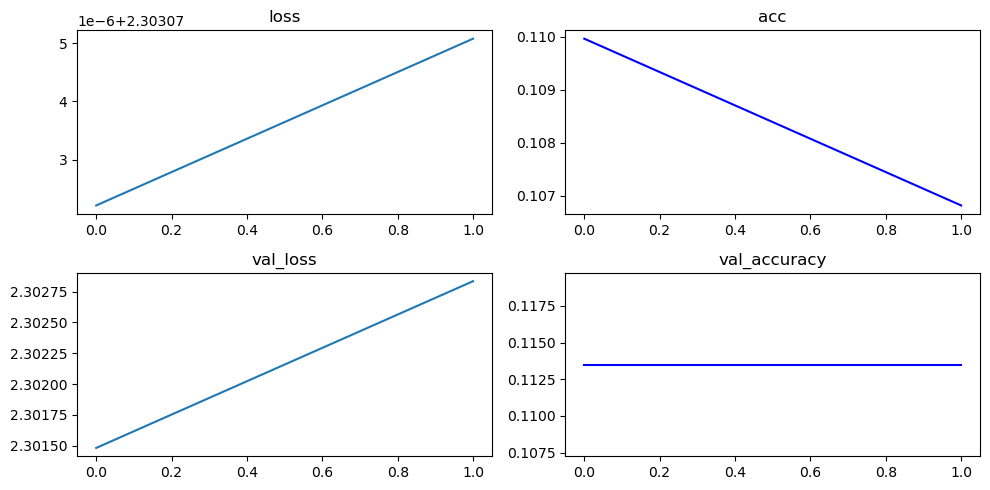

In [16]:
plt.figure(figsize=(10, 5))
plt.subplot(221)
plt.plot(hist.history['loss'])
plt.title("loss")
plt.subplot(222)
plt.plot(hist.history['accuracy'], 'b-')
plt.title("acc")
plt.subplot(223)
plt.plot(hist.history['val_loss'])
plt.title("val_loss")
plt.subplot(224)
plt.plot(hist.history['val_accuracy'], 'b-')
plt.title("val_accuracy")

plt.tight_layout()
plt.show()